In [3]:
!pip install qiskit qiskit-aer matplotlib numpy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.6 MB/s eta 0:00:00


In [20]:
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, ReadoutError

# reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)

# create folders to save results
os.makedirs("results", exist_ok=True)
os.makedirs("notebooks", exist_ok=True)

print("Environment ready. Qiskit version:", __import__('qiskit').__version__)

Environment ready. Qiskit version: 2.2.3


In [21]:
!pip install pylatexenc


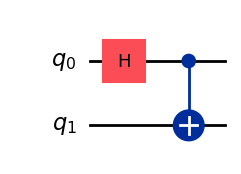

In [22]:
from qiskit import QuantumCircuit
def build_bell_circuit():
    qc=QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    return qc

qc = build_bell_circuit()
qc.draw('mpl')

In [23]:
from qiskit_aer import Aer
sv_sim = Aer.get_backend('aer_simulator')
qc_sv = qc.copy()
qc_sv.save_statevector()
job = sv_sim.run(qc_sv) # Use backend.run() instead of deprecated execute()
res = job.result()
ideal_state = res.get_statevector()
print("Ideal statevector length:", len(ideal_state))

Ideal statevector length: 4


/tmp/ipython-input-3764724200.py:8: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("Ideal statevector length:", len(ideal_state))


In [24]:
from qiskit_aer.noise import pauli_error, thermal_relaxation_error, NoiseModel, depolarizing_error, ReadoutError
def noise_model_depolarizing(depol_prob=0.0, readout_error_prob=0.0):
    nm = NoiseModel()
    # single-qubit depolarizing on gates
    single_err = depolarizing_error(depol_prob, 1)
    twoq_err = depolarizing_error(depol_prob*2, 2)  # scale for 2-qubit gates if you want
    # apply to common gates
    nm.add_all_qubit_quantum_error(single_err, ['u1','u2','u3','id','rz','sx','x','h'])
    nm.add_all_qubit_quantum_error(twoq_err, ['cx','cz','swap'])
    # simple readout error
    if readout_error_prob > 0:
        readout = ReadoutError([[1-readout_error_prob, readout_error_prob],
                                [readout_error_prob, 1-readout_error_prob]])
        nm.add_all_qubit_readout_error(readout)
    return nm


In [25]:
from qiskit_aer import Aer # Import Aer as it is needed
from qiskit.quantum_info import state_fidelity
RNG_SEED = 42
def run_statevector_sim(qc, noise_model=None, shots=0, seed_sim=None):
    # For statevector access, use aer_simulator with save_statevector()
    backend = Aer.get_backend('aer_simulator')
    circ = qc.copy()

    if noise_model is not None:
        # When noise is present, simulate density matrix and retrieve density matrix
        circ.save_density_matrix()
        job = backend.run(circ, noise_model=noise_model, shots=shots, method="density_matrix", seed_simulator=seed_sim)
        res = job.result()
        sv_or_dm = res.data(0)['density_matrix'] # Fixed: Access density matrix directly from data
    else:
        # Otherwise, simulate statevector and retrieve statevector
        circ.save_statevector()
        job = backend.run(circ, noise_model=noise_model, shots=shots, method="statevector", seed_simulator=seed_sim)
        res = job.result()
        sv_or_dm = res.get_statevector()
    return sv_or_dm

# Quick test: ideal
# RNG_SEED and state_fidelity need to be available in scope for this test
# If this cell is run independently, ensure these are imported/defined.
# For notebook flow, they are typically defined in earlier cells.
sv_ideal = run_statevector_sim(qc, noise_model=None, seed_sim=RNG_SEED)
print("Ideal fidelity with itself:", state_fidelity(sv_ideal, sv_ideal))

Ideal fidelity with itself: 1.0


In [26]:
import numpy as np # Import numpy
import pandas as pd # Import pandas
from qiskit.quantum_info import state_fidelity # Import state_fidelity
import os # Import os module to create directories

# Ensure the results directory exists
os.makedirs("results", exist_ok=True)

def compute_fidelity_for_params(qc, depol_vals, readout_vals=None, seeds=None):
    if seeds is None:
        seeds = [int(RNG_SEED+i) for i in range(5)]
    if readout_vals is None:
        readout_vals = [0.0]*len(depol_vals)
    rows = []
    for i, p in enumerate(depol_vals):
        r = readout_vals[i] if i < len(readout_vals) else 0.0
        fidelities = []
        for seed in seeds:
            nm = noise_model_depolarizing(depol_prob=p, readout_error_prob=r)
            sv_noisy = run_statevector_sim(qc, noise_model=nm, seed_sim=seed)
            # compute fidelity with ideal statevector
            f = state_fidelity(ideal_state, sv_noisy)
            fidelities.append(f)
        rows.append({
            "depol_prob": p,
            "readout_prob": r,
            "fidelity_mean": np.mean(fidelities),
            "fidelity_std": np.std(fidelities),
            "num_seeds": len(seeds)
        })
    return pd.DataFrame(rows)

# define sweep
depol_vals = np.linspace(0.0, 0.05, 8)   # 0% to 5% depolarizing
seeds = [1001, 1002, 1003, 1004, 1005]

df = compute_fidelity_for_params(qc, depol_vals, seeds=seeds)
df.to_csv("results/exp1_noise_sweep.csv", index=False)
df

,depol_prob,readout_prob,fidelity_mean,fidelity_std,num_seeds
0,0.000000,0.0,1.000000,0.000000e+00,5
1,0.007143,0.0,0.985765,0.000000e+00,5
2,0.014286,0.0,0.971633,1.110223e-16,5
3,0.021429,0.0,0.957602,0.000000e+00,5
4,0.028571,0.0,0.943673,1.110223e-16,5
5,0.035714,0.0,0.929847,0.000000e+00,5
6,0.042857,0.0,0.916122,0.000000e+00,5
7,0.050000,0.0,0.902500,0.000000e+00,5


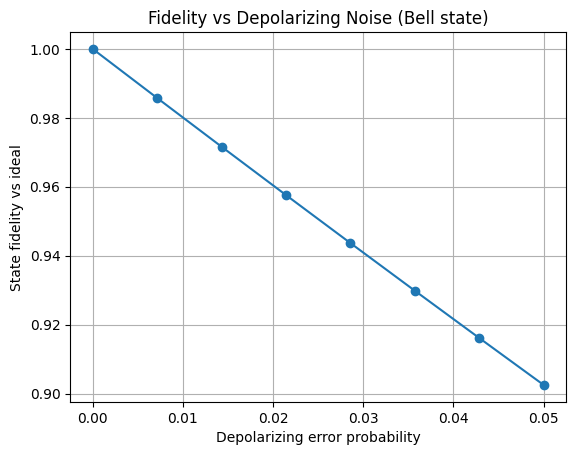

In [27]:
import matplotlib.pyplot as plt # Import matplotlib.pyplot
df = pd.read_csv("results/exp1_noise_sweep.csv")
plt.errorbar(df['depol_prob'], df['fidelity_mean'], yerr=df['fidelity_std'], marker='o', linestyle='-')
plt.xlabel("Depolarizing error probability")
plt.ylabel("State fidelity vs ideal")
plt.title("Fidelity vs Depolarizing Noise (Bell state)")
plt.grid(True)
plt.savefig("results/fig_fidelity_vs_noise.png", dpi=300)
plt.show()

In [28]:
# optional: save per-seed raw fidelities for reproducibility
detailed = []
for p in depol_vals:
    for seed in seeds:
        nm = noise_model_depolarizing(depol_prob=float(p))
        sv_noisy = run_statevector_sim(qc, noise_model=nm, seed_sim=int(seed))
        f = state_fidelity(ideal_state, sv_noisy)
        detailed.append({"depol_prob": float(p), "seed": int(seed), "fidelity": float(f)})
pd.DataFrame(detailed).to_csv("results/exp1_raw_per_seed.csv", index=False)
print("Saved detailed raw CSV")


Saved detailed raw CSV


In [29]:
import time
import json

meta = {
    "experiment": "exp1_noise_sweep",
    "circuit": "bell_2q",
    "depol_vals": depol_vals.tolist(),
    "seeds": seeds,
    "timestamp": time.time(),
    "qiskit_version": __import__('qiskit').__version__
}
with open("results/exp1_meta.json","w") as f:
    json.dump(meta, f, indent=2)

print("All results saved to 'results/' folder:")
!ls -lah results

All results saved to 'results/' folder:
total 140K
drwxr-xr-x 2 root root 4.0K Dec 11 07:14 .
drwxr-xr-x 1 root root 4.0K Dec 11 07:26 ..
-rw-r--r-- 1 root root  386 Dec 11 07:26 exp1_meta.json
-rw-r--r-- 1 root root  448 Dec 11 07:26 exp1_noise_sweep.csv
-rw-r--r-- 1 root root 1.6K Dec 11 07:26 exp1_raw_per_seed.csv
-rw-r--r-- 1 root root  505 Dec 11 07:14 exp2_zne_summary.csv
-rw-r--r-- 1 root root 116K Dec 11 07:26 fig_fidelity_vs_noise.png


experiment 3

experiment 3

In [ ]:
# Imports (safe to re-run)
import os, time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from scipy import stats

from qiskit import QuantumCircuit
from qiskit.quantum_info import state_fidelity, Statevector

# Aer imports (works with qiskit_aer or qiskit depending on your install)
try:
    from qiskit_aer import Aer
    from qiskit_aer.noise import ReadoutError
except Exception:
    from qiskit import Aer
    from qiskit.providers.aer.noise import ReadoutError

backend = Aer.get_backend('aer_simulator')

# Helper: classical fidelity between two probability vectors
def classical_fidelity(p, q, eps=1e-12):
    p = np.array(p, dtype=float)
    q = np.array(q, dtype=float)
    # Small regularization to avoid sqrt(0*neg)
    p = np.clip(p, 0, None)
    q = np.clip(q, 0, None)
    if p.sum() == 0 or q.sum() == 0:
        return 0.0
    p = p / p.sum()
    q = q / q.sum()
    return float((np.sum(np.sqrt(p * q)))**2)

# Helper: compute ideal probabilities from statevector
def ideal_probabilities_from_statevector(sv):
    probs = np.abs(sv)**2
    return (probs / probs.sum()).real

os.makedirs("results", exist_ok=True)
print("Ready. Backend:", backend.name, "Qiskit version:", __import__('qiskit').__version__)

Ready. Backend: aer_simulator Qiskit version: 2.2.3


In [ ]:
# Create measurement-enabled circuit (copy of qc with measurements)
def build_meas_circuit(qc):
    qc_m = qc.copy()
    n = qc.num_qubits
    qc_m.measure_all()
    return qc_m

qc_meas = build_meas_circuit(qc)
qc_meas.draw('mpl')

# quick test: run on ideal simulator with shots to get counts → probabilities
test_job = backend.run(qc_meas, shots=1024)
test_res = test_job.result()
counts = test_res.get_counts()
# convert counts to probability vector in lexical order of states (binary as strings)
states = [format(i, '0{}b'.format(qc.num_qubits)) for i in range(2**qc.num_qubits)]
prob_vec = np.array([counts.get(s,0)/1024 for s in states])
print("Test prob vector (ideal sampling, 1024 shots):", prob_vec)

Test prob vector (ideal sampling, 1024 shots): [0.52636719 0.         0.         0.47363281]


In [ ]:
# Build calibration circuits for all computational basis states for n qubits
def calibration_circuits(n_qubits):
    circuits = []
    labels = []
    for i in range(2**n_qubits):
        b = format(i, '0{}b'.format(n_qubits))
        circ = QuantumCircuit(n_qubits, n_qubits)
        # prepare basis state |b>
        for q, bit in enumerate(reversed(b)):  # reversed to match qiskit's ordering if needed
            if bit == '1':
                circ.x(q)
        circ.measure(range(n_qubits), range(n_qubits))
        circuits.append(circ)
        labels.append(b)
    return circuits, labels

def run_calibration_matrix(n_qubits, noise_model=None, shots=4000, seed_sim=None):
    # returns confusion matrix (rows=true state, cols=observed) normalized by rows
    circs, labels = calibration_circuits(n_qubits)
    job = backend.run(circs, backend=backend, noise_model=noise_model, shots=shots, seed_simulator=seed_sim)
    res = job.result()
    # collect counts
    states = [format(i, '0{}b'.format(n_qubits)) for i in range(2**n_qubits)]
    matrix = np.zeros((2**n_qubits, 2**n_qubits), dtype=float)
    for i, lab in enumerate(labels):
        cnts = res.get_counts(i)
        total = sum(cnts.values())
        for j, s in enumerate(states):
            matrix[i, j] = cnts.get(s, 0) / (total if total>0 else 1)
    return matrix, labels, states

# Quick test on no noise
mat, labels, states = run_calibration_matrix(qc.num_qubits, noise_model=None, shots=2048)
print("Calibration matrix (no noise) row-sum (should be 1):", mat.sum(axis=1))
mat


Calibration matrix (no noise) row-sum (should be 1): [1. 1. 1. 1.]


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
# Core routine: for a given noise_model and shots perform:
# 1) calibration -> get confusion matrix -> inv (mitigation matrix)
# 2) run qc_meas to get counts -> convert to probs
# 3) apply mitigation by multiplying inv_matrix @ obs_probs
# returns raw_prob_vec, mitigated_prob_vec, raw_classical_fidelity, mitigated_classical_fidelity

def run_measurement_and_mitigate(qc_meas, ideal_prob, noise_model, shots=8192, shots_cal=3000, seed_sim=None):
    n = qc_meas.num_qubits
    # 1) calibration
    cal_mat, _, states = run_calibration_matrix(n, noise_model=noise_model, shots=shots_cal, seed_sim=seed_sim)
    # stabilize & invert
    # If matrix is ill-conditioned, regularize by small diag addition
    eps = 1e-8
    try:
        inv_mat = np.linalg.inv(cal_mat + np.eye(cal_mat.shape[0])*eps)
    except np.linalg.LinAlgError:
        inv_mat = np.linalg.pinv(cal_mat)  # fallback
    # 2) run main circuit
    job = backend.run(qc_meas, backend=backend, noise_model=noise_model, shots=shots, seed_simulator=seed_sim)
    res = job.result()
    counts = res.get_counts()
    states = [format(i, '0{}b'.format(n)) for i in range(2**n)]
    obs_probs = np.array([counts.get(s,0)/shots for s in states], dtype=float)
    # 3) mitigate
    mitigated = inv_mat.dot(obs_probs)
    # clip and renormalize
    mitigated = np.clip(mitigated, 0, None)
    if mitigated.sum() > 0:
        mitigated = mitigated / mitigated.sum()
    else:
        mitigated = np.ones_like(mitigated)/len(mitigated)
    # compute classical fidelities vs ideal probabilities
    raw_fid = classical_fidelity(ideal_prob, obs_probs)
    mit_fid = classical_fidelity(ideal_prob, mitigated)
    return obs_probs, mitigated, raw_fid, mit_fid, cal_mat

# quick smoke test (no noise)
ip = ideal_probabilities_from_statevector(ideal_state)
obs, mit, rf, mf, cm = run_measurement_and_mitigate(qc_meas, ip, noise_model=None, shots=2048, shots_cal=1024, seed_sim=123)
print("raw fid:", rf, "mitigated fid:", mf)


raw fid: 0.999994039499995 mitigated fid: 0.999994039499995


In [ ]:
# ZNE measurement sweep:
base_depol = 0.01
scale_factors = [1.0, 2.0, 3.0]
seeds = [201,202,203]   # 3 seeds for manageable runtime; increase for final runs
shots = 8192
shots_cal = 3000

rows = []
for scale in scale_factors:
    dep = base_depol * scale
    # build noise model with readout error too if desired; keep readout small like 0.02 for realism
    nm = noise_model_depolarizing(depol_prob=dep, readout_error_prob=0.02)
    # run multiple seeds to average
    raw_fids = []
    mit_fids = []
    for s in seeds:
        obs_p, mit_p, raw_fid, mit_fid, cal_mat = run_measurement_and_mitigate(qc_meas, ip, noise_model=nm, shots=shots, shots_cal=shots_cal, seed_sim=s)
        raw_fids.append(raw_fid)
        mit_fids.append(mit_fid)
    rows.append({
        "scale": float(scale),
        "depol_prob": float(dep),
        "raw_fidelity_mean": float(np.mean(raw_fids)),
        "raw_fidelity_std": float(np.std(raw_fids)),
        "mitigated_fidelity_mean": float(np.mean(mit_fids)),
        "mitigated_fidelity_std": float(np.std(mit_fids)),
        "num_seeds": len(seeds)
    })
df_meas = pd.DataFrame(rows)
df_meas.to_csv("results/exp3_measurement_zne_summary.csv", index=False)
df_meas


,scale,depol_prob,raw_fidelity_mean,raw_fidelity_std,mitigated_fidelity_mean,mitigated_fidelity_std,num_seeds
0,1.0,0.01,0.950829,0.000995,0.994635,0.003267,3
1,2.0,0.02,0.942204,0.000291,0.990348,0.003639,3
2,3.0,0.03,0.932845,0.000405,0.984675,0.002856,3


In [ ]:
# Fit polynomial (deg2) to mitigated fidelity vs scale and extrapolate to 0
x = df_meas['scale'].to_numpy()
y_mit = df_meas['mitigated_fidelity_mean'].to_numpy()

p_mit = Polynomial.fit(x, y_mit, deg=2).convert()
extrap_mit_0 = float(p_mit(0.0))

# Fit linear as reference
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y_mit)
extrap_lin_mit_0 = float(intercept)

print("Mitigated poly-extrap @0:", extrap_mit_0)
print("Mitigated linear-extrap @0:", extrap_lin_mit_0)
print("Linear R^2:", r_value**2)

# Save fit info
df_meas['poly_fit'] = [float(p_mit(xx)) for xx in x]
df_meas.to_csv("results/exp3_measurement_zne_with_fit.csv", index=False)


Mitigated poly-extrap @0: 0.9975358517887994
Mitigated linear-extrap @0: 0.9998468970168327
Linear R^2: 0.993581593069514


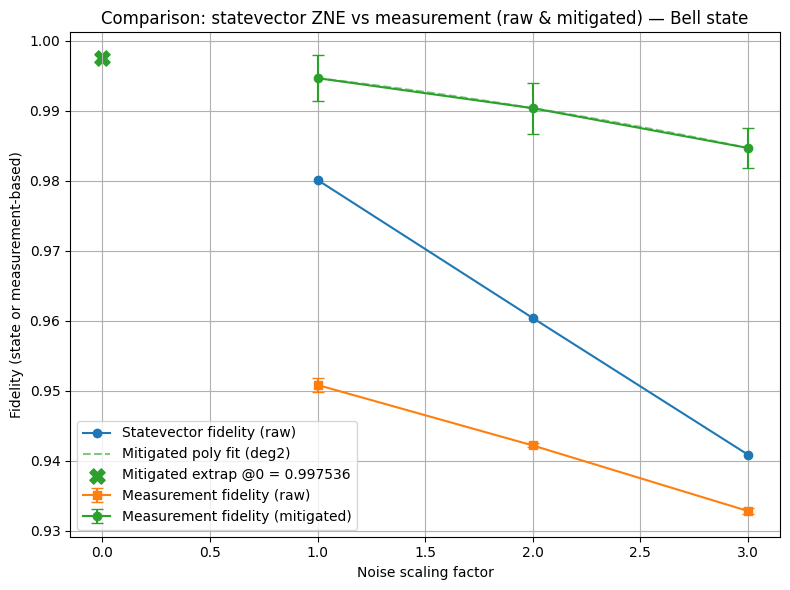

In [ ]:
# Load statevector ZNE if available (df_zne from earlier)
have_statevec = ('df_zne' in globals())

plt.figure(figsize=(8,6))

# Plot statevector ZNE (if exists)
if have_statevec:
    sx = df_zne['scale'].to_numpy()
    sy = df_zne['fidelity_mean'].to_numpy()
    plt.plot(sx, sy, 'o-', label='Statevector fidelity (raw)', color='C0')

# Plot raw measurement fidelity
plt.errorbar(df_meas['scale'], df_meas['raw_fidelity_mean'], yerr=df_meas['raw_fidelity_std'], fmt='s-', label='Measurement fidelity (raw)', color='C1', capsize=4)

# Plot mitigated measurement fidelity and poly extrapolation
plt.errorbar(df_meas['scale'], df_meas['mitigated_fidelity_mean'], yerr=df_meas['mitigated_fidelity_std'], fmt='o-', label='Measurement fidelity (mitigated)', color='C2', capsize=4)
x_fine = np.linspace(min(df_meas['scale']), max(df_meas['scale']), 200)
y_poly_mit = [float(p_mit(xx)) for xx in x_fine]
plt.plot(x_fine, y_poly_mit, '--', label='Mitigated poly fit (deg2)', color='C2', alpha=0.6)

# Extrapolated mitigated @0
plt.scatter([0.0], [extrap_mit_0], marker='X', s=120, color='C2', label=f'Mitigated extrap @0 = {extrap_mit_0:.6f}')

plt.xlabel("Noise scaling factor")
plt.ylabel("Fidelity (state or measurement-based)")
plt.title("Comparison: statevector ZNE vs measurement (raw & mitigated) — Bell state")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/exp3_comparison_plot.png", dpi=300)
plt.show()


In [ ]:
meta = {
    "experiment": "exp3_measurement_zne",
    "base_depol": base_depol,
    "scale_factors": scale_factors,
    "seeds": seeds,
    "shots": shots,
    "shots_cal": shots_cal,
    "timestamp": time.time(),
    "qiskit_version": __import__('qiskit').__version__
}
with open("results/exp3_meta.json","w") as f:
    json.dump(meta, f, indent=2)

print("Saved results and meta. Files in results/:")
!ls -lah results


Saved results and meta. Files in results/:
total 612K
drwxr-xr-x 2 root root 4.0K Dec  8 18:16 .
drwxr-xr-x 1 root root 4.0K Dec  8 13:38 ..
-rw-r--r-- 1 root root  388 Dec  8 16:42 exp1_meta.json
-rw-r--r-- 1 root root  448 Dec  8 14:16 exp1_noise_sweep.csv
-rw-r--r-- 1 root root 1.6K Dec  8 14:21 exp1_raw_per_seed.csv
-rw-r--r-- 1 root root  230 Dec  8 18:06 exp2_zne_meta.json
-rw-r--r-- 1 root root 181K Dec  8 18:05 exp2_zne_plot.png
-rw-r--r-- 1 root root  558 Dec  8 18:06 exp2_zne_raw_per_seed.csv
-rw-r--r-- 1 root root  505 Dec  8 18:04 exp2_zne_summary.csv
-rw-r--r-- 1 root root  571 Dec  8 18:05 exp2_zne_summary_with_fit.csv
-rw-r--r-- 1 root root 257K Dec  8 18:16 exp3_comparison_plot.png
-rw-r--r-- 1 root root  387 Dec  8 18:15 exp3_measurement_zne_summary.csv
-rw-r--r-- 1 root root  453 Dec  8 18:16 exp3_measurement_zne_with_fit.csv
-rw-r--r-- 1 root root  262 Dec  8 18:16 exp3_meta.json
-rw-r--r-- 1 root root 116K Dec  8 14:21 fig_fidelity_vs_noise.png
